## Goodreads Book Recommender

#### **Introduction**

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### **Contents**

**Part 0: Preprocessing**
- 0.1 - Load and Prepare Data
- 0.1 - Write Functions to Process Recommendations

**Part 1: Collaborative Filtering Based on Reader Similarity with KNN**
- 1.1 - Find Similar Readers
- 1.2 - Generate Recommendations

**Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization**
- 2.1 - Factorize User-Rating Matrix with SVD
- 2.2 - Generate Recommendations by Predicting Ratings
- 2.3 - Matrix Factorization with Gradient Descen

## Part 0: Preprocessing

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds
from skimage import io
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import AutoMinorLocator

In [121]:
# Set global variable of "sparse" or "dense"
# "sparse" will have user-item matrix with all books, "dense" only those in df_books
SPARSITY = "dense" 

# Choose K for small med and large neighborhoods
SM, MD, LG = 150, 1000, 3500

# For books in my_books where there's a better book id to assign it for matching
ids_to_replace = {    
    40514364:25499718, # Children of Time
    40961621:347610, # King Leopold's Ghost
    33395538:32191710, # Astrophysics for People in a Hurry
    33854198:875808, # Man-Eaters Of Kumaon
    44767458:234225, # Dune
    25772375:234225 # Dune (export sometimes generates this ID)
}

### 0.1 - Load and Prepare Data

In [122]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres, how="left", on="book_id")

# Filter out kids books
df_books = df_books[df_books.loc[:,"children":"comic"].sum(axis=1) < 2]

In [123]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [124]:
# Create df_reviews that is less sparse than original
if SPARSITY == "dense":
    in_df_books = book_index["book_id"].isin(df_books["book_id"])
    book_index = book_index[in_df_books].reset_index().drop("index", axis=1)
    df_reviews = df_reviews[:, in_df_books]
print(f"User-Item Matrix: {df_reviews.shape[0]:,} readers by {df_reviews.shape[1]:,} books")    

User-Item Matrix: 245,119 readers by 315,354 books


In [125]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")
# my_books["Title"].replace(titles_to_replace, inplace=True)
my_books["Book Id"].replace(ids_to_replace, inplace=True)

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# First match on book_id
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="inner", on="book_id", suffixes=["_mb","_dfb"]
            ).rename(columns={"title_dfb":"title"}).drop("title_mb", axis=1)
print(f"Matching on book_id: {my_books_1.shape[0]}")

# Next match on title
my_books_2 = pd.merge(
    my_books[~my_books["book_id"].isin(my_books_1["book_id"])], # not matched on id
    df_books[["book_id", "title", "ratings_count", "avg_rating"]], 
    how="inner", on="title", suffixes=["_mb","_dfb"]
    ).sort_values(["title", "ratings_count"], ascending=False)\
     .drop_duplicates(subset=["title"])\
     .rename(columns={"book_id_dfb":"book_id"})
print(f"Matching on title: {my_books_2[~my_books_2['book_id'].isin(my_books_1['book_id'])].shape[0]}")

# Concat matching on book_id and matching on title
my_books_3 = pd.concat([my_books_1, my_books_2[["book_id", "rating", "title"]]])\
               .drop_duplicates(subset="title")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

# Reshape to sparse matrix dimensions
my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers
norm = Normalizer()
row_norms = np.sqrt(np.sum(df_reviews.power(2), axis=1)) # save row norms to un-normalzie later
df_reviews = norm.fit_transform(df_reviews) 

Target reader ratings: 176
Matching on book_id: 93
Matching on title: 19
Total matches: 112, 63.64% of total


In [126]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [127]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i] * float(row_norms[int(nt.user)])) 
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#(?:[2-9]|[1-9]\d+)"
    regex2 = r"Vol. (?:[0-9]|[1-9]\d+)"
    regex3 = r"Volume (?:[0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings, dists

In [128]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=100, n_recs=20, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))   

    others_ratings = others.groupby("book_id")["user_rating"].mean()\
                                                .reset_index()\
                                                .rename(columns={"user_rating":"similar_usr_avg"})

    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url", "book_id"])["uid"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g").sort_values(by="predicted_rating", 
                                                                                   ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )
        
        highest_rated_recs_genre = pd.merge(highest_rated_recs_genre, others_ratings, how="left", on="book_id")
        
        highest_rated_recs_genre["similar_usr_avg"] = highest_rated_recs_genre["similar_usr_avg"].round(2)
        
        cols = ["title", "avg_rating", "similar_usr_avg", "ratings_count", "year", "url"]
        highest_rated_recs_genre = highest_rated_recs_genre[cols]

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre.head(50))

        print(gs)
        display(highest_rated_recs_genre.head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [129]:
# Function to show most popular books among similar readers
def neighbors_most_popular(others, n=20, min_ratings=100, min_score=3.9, write_to_excel=False):
    
    others = pd.merge(others.groupby("book_id")["user_rating"].mean()\
                            .reset_index().rename(columns={"user_rating":"similar_usr_avg"}),
                      others,
                      on="book_id")
    others["similar_usr_avg"] = others["similar_usr_avg"].round(2)

    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "similar_usr_avg", "ratings_count", "year", "url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"%_similar_usr_read"})

    popular_recs["%_similar_usr_read"] = (popular_recs["%_similar_usr_read"] / 
                                            others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[
        ["title","avg_rating","similar_usr_avg", "ratings_count","year","%_similar_usr_read","url"]
    ]

In [130]:
# Function to show top rated among similar readers
def neighbors_top_rated(others, n=20, min_ratings=100, min_score=3.9, write_to_excel=False):

    others = pd.merge(others.groupby("book_id")["user_rating"].mean()\
                            .reset_index().rename(columns={"user_rating":"similar_usr_avg"}),
                      others,
                      on="book_id")
    others["similar_usr_avg"] = others["similar_usr_avg"].round(2)
    
    min_neighbor_ratings = np.max([others["uid"].nunique() / 200, 5])

    highest_rated_recs = others.query(
                "ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "similar_usr_avg", "ratings_count", "year", "url"])["uid"]\
        .count().reset_index().sort_values(by=["similar_usr_avg", "avg_rating", "uid"], ascending=False)\
        .query("uid >= @min_neighbor_ratings")\
        .nlargest(n, "similar_usr_avg").drop(columns="uid")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [131]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):

    # Get genre rankings for target and neighbors
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})
    target_genre_ranking = target_genre_ranking.div(target_genre_ranking.sum(axis=0), axis=1)

    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"neighbor"})
    neighbor_genre_ranking = neighbor_genre_ranking.div(neighbor_genre_ranking.sum(axis=0), axis=1)

    genre_rankings = pd.merge(
            target_genre_ranking, neighbor_genre_ranking, left_index=True, right_index=True
            ).reset_index()

    # Plot target genre pref
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='target',
        s=150,
        edgecolors='black',
        color="mediumslateblue",
        linewidths = 0.75,
        label='Target Reader',
        zorder=2,
        )

    # Plot neighbors genre pref
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='neighbor',
        label='Similar Readers',
        color="darkgray",
        s=150,
        zorder=3
        )

    # Iterate through each genre and plot line connecting 2 points
    for ind in list(genre_rankings['index']):
    
        # Plot line connecting points
        plt.plot([genre_rankings[genre_rankings['index']==ind]['target'],
                    genre_rankings[genre_rankings['index']==ind]['neighbor']],
                    [ind, ind],
                    color='#565A5C',
                    alpha=0.2,                    
                    # linestyle=(0, (1,1)),
                    linewidth=6.5,
                    zorder=1
                    )

    # Set chart details
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderpad=1)
    ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
    ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
    plt.xlabel("Genre preference")
    plt.ylabel(None)
    plt.title('Top Genres for Target Reader and Similar Readers', fontsize=14)
    plt.show()

In [132]:
def display_top_books(preds, books, target_ratings):
    """
    Plots book cover images for top recommendations in top 5 genres

    Args:
        preds: prediction df yielded by get_recs()
        books: dataframe with all book info
        target_ratings: target user's book ratings

    Returns:
        None
    """
    # Get image_url for top preds
    plot_pred = pd.merge(
                    preds[["book_id", "predicted_rating"]], 
                    books[["book_id", "image_url", "main_genre"]], 
                    on="book_id"
                )

    # For each of the top 10 genres, get top 5 books
    top_genres = pd.DataFrame(target_ratings.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})[0:5]

    # Function to turn image url into image 
    def getImage(path, zoom=0.3):
        return OffsetImage(io.imread(path), zoom=zoom)

    # Plot
    fig, ax = plt.subplots(figsize=(13,7))
    for i in range(len(top_genres)): # For each of top genres
        genre = top_genres.index[i]
        g = float(genre[6:]) # Get genre number
        
        # Slice plot pred to genre and valid image url
        books_to_plot = plot_pred[ 
            (plot_pred["main_genre"] == g) & (plot_pred["image_url"].str.contains("images.gr-"))
            ].head(5)
        
        paths = [url for url in books_to_plot["image_url"]] # Get image urls
        x = [i * 10 + 10 for x in range(5)] # Set genre bucket
        y = [y for y in books_to_plot["predicted_rating"]] # get predicted rating as y

        # Plot
        ax.scatter(x,y,alpha=0) 

        # Plot image at xy
        for x0, y0, path in zip(x, y, paths):
            ab = AnnotationBbox(getImage(path), (x0 + np.random.uniform(-3.5,3.5), y0), frameon=True, pad=0.3)
            ax.add_artist(ab)
        
    plt.ylabel("Recommendation Strength", fontsize=12)
    plt.xlabel("\nGenre Grouping", fontsize=12)
    plt.title("Top Recommendations by Genre", y=1.02, fontsize=14)
    plt.xlim((5, 55))
    ax.spines[['right', 'top', 'left']].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    ax.yaxis.set_ticklabels([])
    ax.yaxis.grid(True, alpha=0.3) # Create y gridlines
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.grid(which="minor", visible=True, alpha=0.8) # Create x gridlines
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

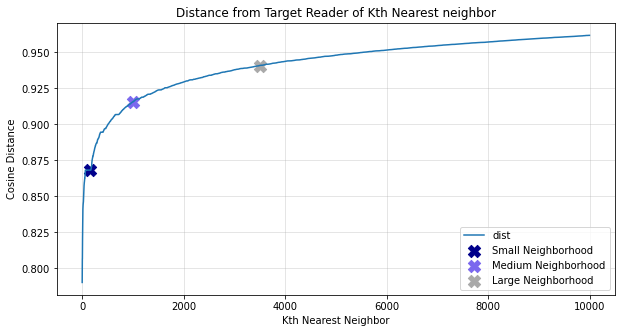

In [133]:
# Take a very large neighborhood to see how reader similarity decreases with K
n, t, dists = find_neighbors(10000, target, df_reviews, book_index, df_books)

# Plot distance by kth closest neighbor
fig, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(dists.T).rename(columns={0:"dist"})[1:10000].plot(ax=ax)
plt.title("Distance from Target Reader of Kth Nearest neighbor")
plt.xlabel("Kth Nearest Neighbor")
plt.ylabel("Cosine Distance")
ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
plt.scatter(SM, dists[0,SM], color="darkblue", marker="X", label="Small Neighborhood", s=150)
plt.scatter(MD, dists[0,MD], color="mediumslateblue", marker="X", label="Medium Neighborhood", s=150)
plt.scatter(LG, dists[0,LG], color="darkgray", marker="X", label="Large Neighborhood", s=150)
plt.legend()
plt.show()

In [134]:
# Perform KNN on user rating matrix
sm_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        SM, target, df_reviews, book_index, df_books)

# Find med number of similar users than before to get broader pool of potentially relevant books
med_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                    MD, target, df_reviews, book_index, df_books)

# Find larger number of similar users 
lg_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        LG, target, df_reviews, book_index, df_books)

print(f"Small neighborhood contains {sm_neighborhood_ratings['book_index'].nunique():,} books, " \
        f"{sm_neighborhood_ratings['uid'].nunique():,} readers")
print(f"Medium neighborhood contains {med_neighborhood_ratings['book_index'].nunique():,} books, " \
        f"{med_neighborhood_ratings['uid'].nunique():,} readers")
print(f"Large neighborhood contains {lg_neighborhood_ratings['book_index'].nunique():,} books, " \
        f"{lg_neighborhood_ratings['uid'].nunique():,} readers")

Small neighborhood contains 558 books, 58 readers
Medium neighborhood contains 6,022 books, 844 readers
Large neighborhood contains 22,538 books, 3,286 readers


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

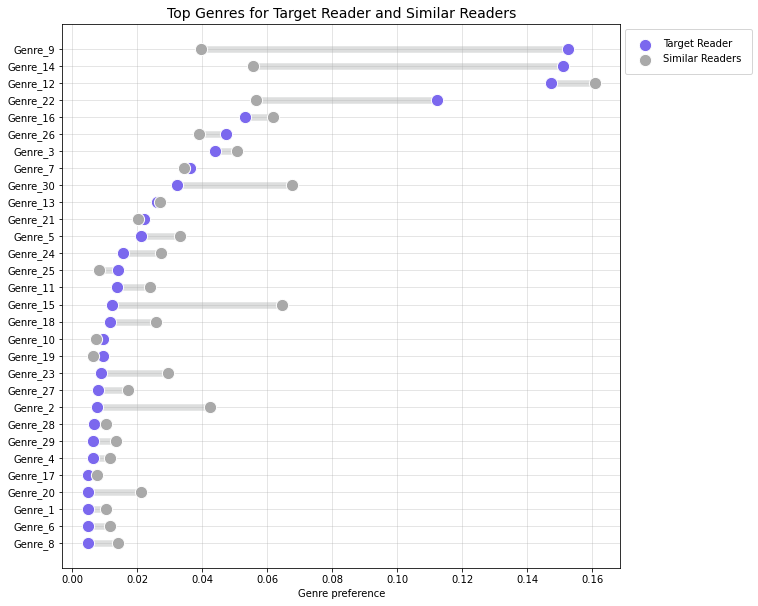

In [135]:
# Show top genres
plot_top_genres(sm_neighborhood_ratings, target_user_ratings)

In [136]:
# View most popular books among neighbors
neighbors_most_popular(sm_neighborhood_ratings, 15, write_to_excel=False)

,title,avg_rating,similar_usr_avg,ratings_count,year,%_similar_usr_read,url
171,Ready Player One,4.31,4.29,376328.0,2011.0,12.1%,https://www.goodreads.com/book/show/9969571-re...
327,"The Way of Kings (The Stormlight Archive, #1)",4.64,4.60,151473.0,2010.0,8.6%,https://www.goodreads.com/book/show/7235533-th...
286,The Martian,4.39,4.00,435440.0,2014.0,8.6%,https://www.goodreads.com/book/show/18007564-t...
154,"Old Man's War (Old Man's War, #1)",4.23,3.60,100702.0,2007.0,8.6%,https://www.goodreads.com/book/show/51964.Old_...
62,Dark Matter,4.10,3.20,75794.0,2016.0,8.6%,https://www.goodreads.com/book/show/27833670-d...
292,The Name of the Wind (The Kingkiller Chronicle...,4.55,4.50,416634.0,2007.0,6.9%,https://www.goodreads.com/book/show/186074.The...
276,"The Hunger Games (The Hunger Games, #1)",4.34,3.50,4899965.0,2008.0,6.9%,https://www.goodreads.com/book/show/2767052-th...
18,All the Light We Cannot See,4.31,4.50,498685.0,2014.0,6.9%,https://www.goodreads.com/book/show/18143977-a...
131,"Leviathan Wakes (The Expanse, #1)",4.20,4.00,72492.0,2011.0,6.9%,https://www.goodreads.com/book/show/8855321-le...
200,Snow Crash,4.02,3.25,179029.0,2000.0,6.9%,https://www.goodreads.com/book/show/830.Snow_C...


In [137]:
# View highest rated books among similar readers
neighbors_top_rated(sm_neighborhood_ratings, 15, write_to_excel=False)

,title,avg_rating,similar_usr_avg,ratings_count,year,url
327,"The Way of Kings (The Stormlight Archive, #1)",4.64,4.60,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
171,Ready Player One,4.31,4.29,376328.0,2011.0,https://www.goodreads.com/book/show/9969571-re...
286,The Martian,4.39,4.00,435440.0,2014.0,https://www.goodreads.com/book/show/18007564-t...
154,"Old Man's War (Old Man's War, #1)",4.23,3.60,100702.0,2007.0,https://www.goodreads.com/book/show/51964.Old_...
62,Dark Matter,4.10,3.20,75794.0,2016.0,https://www.goodreads.com/book/show/27833670-d...


In [138]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=sm_neighborhood_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=10, 
    min_score=3.9, 
    n_recs=15,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Josephine B Trilogy,4.45,4.0,132.0,2006.0,https://www.goodreads.com/book/show/1308176.Th...
1,The Godfather,4.36,4.0,259150.0,2002.0,https://www.goodreads.com/book/show/22034.The_...
2,India After Gandhi: The History of the World's...,4.35,4.0,9652.0,2007.0,https://www.goodreads.com/book/show/356824.Ind...
3,A Thousand Splendid Suns,4.34,3.0,835172.0,2007.0,https://www.goodreads.com/book/show/128029.A_T...
4,On Writing: A Memoir of the Craft,4.31,4.0,135528.0,2002.0,https://www.goodreads.com/book/show/10569.On_W...
5,The Emperor of All Maladies: A Biography of Ca...,4.29,5.0,49534.0,2010.0,https://www.goodreads.com/book/show/7170627-th...
6,V for Vendetta,4.25,5.0,212464.0,2005.0,https://www.goodreads.com/book/show/5805.V_for...
7,Bury My Heart at Wounded Knee: An Indian Histo...,4.21,5.0,41180.0,2001.0,https://www.goodreads.com/book/show/76401.Bury...
8,The Red Tent,4.16,4.0,428809.0,2005.0,https://www.goodreads.com/book/show/4989.The_R...
9,North and South,4.13,2.0,98068.0,1994.0,https://www.goodreads.com/book/show/156538.Nor...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,On Tyranny: Twenty Lessons from the Twentieth ...,4.29,4.0,9145.0,2017.0,https://www.goodreads.com/book/show/33917107-o...
1,Our Revolution: A Future to Believe In,4.29,3.0,2430.0,2016.0,https://www.goodreads.com/book/show/31741420-o...
2,Elon Musk: Inventing the Future,4.24,3.0,63849.0,2015.0,https://www.goodreads.com/book/show/22543496-e...
3,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,5.0,11750.0,2015.0,https://www.goodreads.com/book/show/22535480-e...
4,Hun Sen’s Cambodia,4.20,3.0,105.0,2014.0,https://www.goodreads.com/book/show/21945075-h...
5,"Titan: The Life of John D. Rockefeller, Sr.",4.19,4.0,8970.0,2004.0,https://www.goodreads.com/book/show/16121.Titan
6,The Sleepwalkers: How Europe Went to War in 1914,4.18,4.0,3830.0,2012.0,https://www.goodreads.com/book/show/18669169-t...
7,"Blood Meridian, or the Evening Redness in the ...",4.18,5.0,72755.0,1992.0,https://www.goodreads.com/book/show/394535.Blo...
8,Daemon (Daemon #1),4.17,2.0,9355.0,2009.0,https://www.goodreads.com/book/show/6665847-da...
9,Amusing Ourselves to Death: Public Discourse i...,4.15,3.0,10133.0,1985.0,https://www.goodreads.com/book/show/74034.Amus...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,A Night Without Stars,4.41,5.00,1758.0,2016.0,https://www.goodreads.com/book/show/28530221-a...
1,The Martian,4.39,4.00,435440.0,2014.0,https://www.goodreads.com/book/show/18007564-t...
2,The Stand,4.34,2.00,449730.0,1978.0,https://www.goodreads.com/book/show/149267.The...
3,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,3.67,17174.0,2016.0,https://www.goodreads.com/book/show/32109569-w...
4,Judas Unchained,4.30,4.50,21306.0,2005.0,https://www.goodreads.com/book/show/45244.Juda...
5,"This Book Is Full of Spiders: Seriously, Dude,...",4.26,3.00,294.0,2013.0,https://www.goodreads.com/book/show/17286949-t...
6,"Pandora's Star (Commonwealth Saga, #1)",4.24,4.00,1312.0,2006.0,https://www.goodreads.com/book/show/6136470-pa...
7,"Old Man's War (Old Man's War, #1)",4.23,3.60,100702.0,2007.0,https://www.goodreads.com/book/show/51964.Old_...
8,Understand,4.22,4.00,869.0,2006.0,https://www.goodreads.com/book/show/7234685-un...
9,The Abyss Beyond Dreams,4.21,5.00,4944.0,2014.0,https://www.goodreads.com/book/show/20697413-t...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Behave: The Biology of Humans at Our Best and ...,4.40,5.00,830.0,2017.0,https://www.goodreads.com/book/show/31170723-b...
1,The Authoritarians,4.31,5.00,354.0,2006.0,https://www.goodreads.com/book/show/1971601.Th...
2,Chess Story,4.28,5.00,17661.0,2005.0,https://www.goodreads.com/book/show/59151.Ches...
3,Stories of Your Life and Others,4.27,4.67,17769.0,2010.0,https://www.goodreads.com/book/show/223380.Sto...
4,Writing Great Fiction: Storytelling Tips and T...,4.24,4.00,381.0,2014.0,https://www.goodreads.com/book/show/24235595-w...
5,The Hero With a Thousand Faces,4.24,4.00,18378.0,1972.0,https://www.goodreads.com/book/show/588138.The...
6,Dear Data,4.22,2.00,227.0,2016.0,https://www.goodreads.com/book/show/28465052-d...
7,Meditations,4.20,5.00,45727.0,2006.0,https://www.goodreads.com/book/show/30659.Medi...
8,"The Diamond Age: or, A Young Lady's Illustrate...",4.19,4.00,62866.0,2000.0,https://www.goodreads.com/book/show/827.The_Di...
9,Guns,4.17,4.00,3687.0,2013.0,https://www.goodreads.com/book/show/17284577-guns


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Pragmatic Programmer: From Journeyman to M...,4.31,5.0,9737.0,1999.0,https://www.goodreads.com/book/show/4099.The_P...
1,Your Deceptive Mind: A Scientific Guide to Cri...,4.30,4.0,1005.0,2012.0,https://www.goodreads.com/book/show/13562148-y...
2,The Dictator's Handbook: Why Bad Behavior is A...,4.27,3.0,2497.0,2011.0,https://www.goodreads.com/book/show/11612989-t...
3,Turn the Ship Around!: A True Story of Turning...,4.26,2.0,2684.0,2013.0,https://www.goodreads.com/book/show/16158601-t...
4,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,4.0,27705.0,2014.0,https://www.goodreads.com/book/show/18077903-c...
5,The Hard Thing About Hard Things: Building a B...,4.20,2.0,20745.0,2014.0,https://www.goodreads.com/book/show/18176747-t...
6,Deep Work: Rules for Focused Success in a Dist...,4.19,3.0,15605.0,2016.0,https://www.goodreads.com/book/show/25744928-d...
7,Your Best Brain: The Science of Brain Improvement,4.18,3.0,261.0,2014.0,https://www.goodreads.com/book/show/23626805-y...
8,Influence: The Psychology of Persuasion,4.18,5.0,47682.0,2006.0,https://www.goodreads.com/book/show/28815.Infl...
9,Work Rules!: Insights from Inside Google That ...,4.16,3.0,4902.0,2015.0,https://www.goodreads.com/book/show/22875447-w...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Gates of Fire: An Epic Novel of the Battle of ...,4.40,5.0,18299.0,2005.0,https://www.goodreads.com/book/show/1305.Gates...
1,"Dawn of Wonder (The Wakening, #1)",4.35,1.0,13351.0,2015.0,https://www.goodreads.com/book/show/25451852-d...
2,The Emperor's Soul,4.33,5.0,35260.0,2012.0,https://www.goodreads.com/book/show/13578175-t...
3,"The Lies of Locke Lamora (Gentleman Bastard, #1)",4.30,4.0,123373.0,2006.0,https://www.goodreads.com/book/show/127455.The...
4,"Outlander (Outlander, #1)",4.21,5.0,531055.0,2005.0,https://www.goodreads.com/book/show/10964.Outl...
5,Elantris,4.17,4.0,1420.0,2011.0,https://www.goodreads.com/book/show/10803709-e...
6,"Elantris (Elantris, #1)",4.17,4.5,100115.0,2006.0,https://www.goodreads.com/book/show/68427.Elan...
7,"Assassin's Apprentice (Farseer Trilogy, #1)",4.14,2.0,133239.0,1996.0,https://www.goodreads.com/book/show/45107.Assa...
8,Jane Eyre,4.10,3.0,1207986.0,1847.0,https://www.goodreads.com/book/show/10210.Jane...
9,"Red Queen (Red Queen, #1)",4.08,3.5,205243.0,2015.0,https://www.goodreads.com/book/show/22328546-r...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Man's Search for Meaning,4.33,3.5,179906.0,2006.0,https://www.goodreads.com/book/show/4069.Man_s...
1,Falling Upward: A Spirituality for the Two Hal...,4.24,4.0,4884.0,2011.0,https://www.goodreads.com/book/show/9963483-fa...
2,The Prophet,4.23,3.0,145579.0,2010.0,https://www.goodreads.com/book/show/2547.The_P...
3,Becoming Wise: An Inquiry into the Mystery and...,4.22,3.0,1683.0,2016.0,https://www.goodreads.com/book/show/25894085-b...
4,"Desiring the Kingdom: Worship, Worldview, and ...",4.22,5.0,1659.0,2009.0,https://www.goodreads.com/book/show/5944774-de...
5,The Screwtape Letters,4.21,3.0,116487.0,2001.0,https://www.goodreads.com/book/show/11149.The_...
6,TED Talks: The Official TED Guide to Public Sp...,4.20,4.0,2368.0,2016.0,https://www.goodreads.com/book/show/25897871-t...
7,Have a Little Faith: a True Story,4.16,4.0,60867.0,2009.0,https://www.goodreads.com/book/show/1255781.Ha...
8,Imagining the Kingdom: How Worship Works,4.15,4.0,390.0,2013.0,https://www.goodreads.com/book/show/15863575-i...
9,The Essential Dalai Lama: His Important Teachings,4.12,3.0,315.0,2006.0,https://www.goodreads.com/book/show/237924.The...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Shoe Dog: A Memoir by the Creator of NIKE,4.44,4.0,27468.0,2016.0,https://www.goodreads.com/book/show/27220736-s...
1,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,5.0,95353.0,1997.0,https://www.goodreads.com/book/show/5544.Surel...
2,Masters of Doom: How Two Guys Created an Empir...,4.23,4.0,7357.0,2004.0,https://www.goodreads.com/book/show/222146.Mas...
3,No One Writes Back,4.19,1.0,154.0,2013.0,https://www.goodreads.com/book/show/17591572-n...
4,The Color Purple,4.17,1.0,380851.0,2004.0,https://www.goodreads.com/book/show/11486.The_...
5,Total Recall: My Unbelievably True Life Story,4.11,5.0,7295.0,2012.0,https://www.goodreads.com/book/show/14546626-t...
6,"Searching for Sunday: Loving, Leaving, and Fin...",4.09,4.0,5560.0,2015.0,https://www.goodreads.com/book/show/22574709-s...
7,The Rest Is Noise: Listening to the Twentieth ...,4.08,4.0,9607.0,2007.0,https://www.goodreads.com/book/show/392563.The...
8,Grace's Guide: The Art of Pretending to Be a G...,4.04,3.0,6917.0,2014.0,https://www.goodreads.com/book/show/22168240-g...
9,On the Move: A Life,4.03,4.0,9163.0,2015.0,https://www.goodreads.com/book/show/24972194-o...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,A Gentleman in Moscow,4.37,3.0,44419.0,2016.0,https://www.goodreads.com/book/show/29430012-a...
1,Jackalope Wives,4.35,5.0,460.0,2014.0,https://www.goodreads.com/book/show/20527580-j...
2,All the Light We Cannot See,4.31,4.5,498685.0,2014.0,https://www.goodreads.com/book/show/18143977-a...
3,"The Pillars of the Earth (Kingsbridge, #1)",4.29,5.0,471990.0,2002.0,https://www.goodreads.com/book/show/5043.The_P...
4,A Good Man is Hard to Find and Other Stories,4.24,5.0,26384.0,1992.0,https://www.goodreads.com/book/show/48464.A_Go...
5,The Waste Lands,4.24,4.0,121199.0,2003.0,https://www.goodreads.com/book/show/34084.The_...
6,The Drawing of the Three,4.23,4.0,143971.0,2003.0,https://www.goodreads.com/book/show/5094.The_D...
7,Neverwhere,4.18,2.0,275822.0,2003.0,https://www.goodreads.com/book/show/14497.Neve...
8,The Amazing Adventures of Kavalier & Clay,4.17,5.0,149976.0,2000.0,https://www.goodreads.com/book/show/3985.The_A...
9,Imajica,4.16,2.0,15828.0,1997.0,https://www.goodreads.com/book/show/567704.Ima...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Arcanum Unbounded: The Cosmere Collection,4.54,4.0,6493.0,2016.0,https://www.goodreads.com/book/show/28595941-a...
1,The Found and the Lost: The Collected Novellas...,4.43,2.0,182.0,2016.0,https://www.goodreads.com/book/show/29868611-t...
2,Beyond the Aquila Rift: The Best of Alastair R...,4.30,4.0,163.0,2016.0,https://www.goodreads.com/book/show/28931839-b...
3,The Circular Ruins,4.30,5.0,409.0,2010.0,https://www.goodreads.com/book/show/28110198-t...
4,2016 on Goodreads,4.25,4.0,1167.0,2016.0,https://www.goodreads.com/book/show/33232571-2...
5,"The Hedge Knight (The Tales of Dunk and Egg, #1)",4.23,3.0,14640.0,2005.0,https://www.goodreads.com/book/show/11970747-t...
6,Sixth of the Dusk,4.21,4.0,8122.0,2014.0,https://www.goodreads.com/book/show/23397921-s...
7,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,3.5,35184.0,1997.0,https://www.goodreads.com/book/show/386162.The...
8,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,3.0,940154.0,1995.0,https://www.goodreads.com/book/show/11.The_Hit...
9,Other People,4.19,4.0,373.0,2012.0,https://www.goodreads.com/book/show/16176131-o...


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

#### 2.1 - Factorize User-Rating Matrix with SVD

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$\mathbf{R} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\top$$ where $\mathbf{U}$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

In [139]:
# Choose neighborhood size for SVD
svd_neighborhood_ratings = lg_neighborhood_ratings

In [140]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"Neighborhood contains {svd_neighbor_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]

Neighborhood contains 22,650 books


In [141]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=40)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [142]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(
                all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

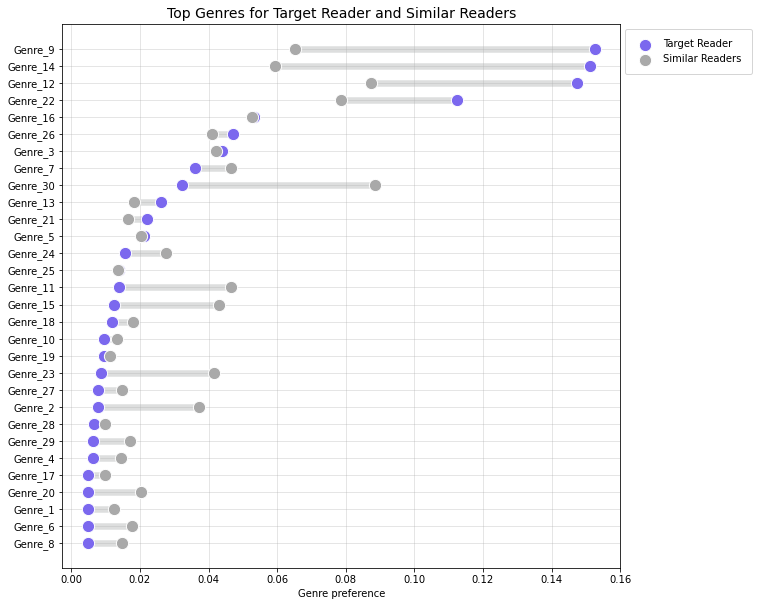

In [143]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [165]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:] * float(row_norms[target])

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [166]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 3.9").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
1,Rediscovering Americanism: And the Tyranny of ...,4.11,1.0,307.0,2017.0,https://www.goodreads.com/book/show/34605923-r...
5,A Bend in the Road,4.02,1.0,117954.0,2005.0,https://www.goodreads.com/book/show/3463.A_Ben...
13,The Pursuit of Glory: Europe 1648-1815,4.09,1.0,454.0,2007.0,https://www.goodreads.com/book/show/345858.The...
14,"Vampire Academy (Vampire Academy, #1)",4.14,1.0,253685.0,2007.0,https://www.goodreads.com/book/show/345627.Vam...
15,The Sabbath: Its Meaning for Modern Man,4.35,1.0,2418.0,1951.0,https://www.goodreads.com/book/show/345500.The...
16,If Chins Could Kill: Confessions of a B Movie ...,3.99,1.0,12180.0,2001.0,https://www.goodreads.com/book/show/34548.If_C...
18,How to Be Perfectly Unhappy,3.91,1.0,150.0,2017.0,https://www.goodreads.com/book/show/34536949-h...
19,No Time for Goodbye,4.00,1.0,1344.0,2008.0,https://www.goodreads.com/book/show/3452756-no...
20,Затворисърце,4.01,1.0,259.0,2017.0,https://www.goodreads.com/book/show/34670017
25,Filter House,3.99,1.0,232.0,2008.0,https://www.goodreads.com/book/show/3477242-fi...


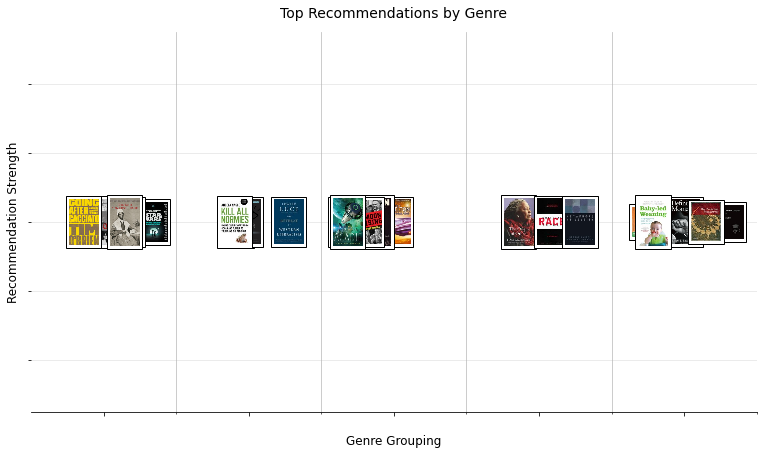

In [167]:
# Display top preds
display_top_books(top_preds, df_books, target_user_ratings)

In [168]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, n=50, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,similar_usr_avg,ratings_count,year,%_similar_usr_read,url
8228,The Martian,4.39,4.27,435440.0,2014.0,9.9%,https://www.goodreads.com/book/show/18007564-t...
5387,Ready Player One,4.31,4.12,376328.0,2011.0,8.1%,https://www.goodreads.com/book/show/9969571-re...
7845,"The Hunger Games (The Hunger Games, #1)",4.34,3.88,4899965.0,2008.0,6.3%,https://www.goodreads.com/book/show/2767052-th...
8365,The Name of the Wind (The Kingkiller Chronicle...,4.55,4.25,416634.0,2007.0,5.6%,https://www.goodreads.com/book/show/186074.The...
7434,The Fault in Our Stars,4.26,4.06,2429317.0,2012.0,5.5%,https://www.goodreads.com/book/show/11870085-t...
1216,Brave New World,3.97,3.88,1043619.0,1998.0,4.4%,https://www.goodreads.com/book/show/5129.Brave...
6786,The Book Thief,4.36,4.34,1193697.0,2005.0,4.1%,https://www.goodreads.com/book/show/19063.The_...
7740,The Handmaid's Tale,4.07,4.00,648783.0,1998.0,4.1%,https://www.goodreads.com/book/show/38447.The_...
8809,The Road,3.95,3.80,513565.0,2006.0,3.6%,https://www.goodreads.com/book/show/6288.The_Road
586,"American Gods (American Gods, #1)",4.11,3.74,379668.0,2005.0,3.5%,https://www.goodreads.com/book/show/4407.Ameri...


In [169]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, n=50, write_to_excel=False)
top_rated.head(20)

,title,avg_rating,similar_usr_avg,ratings_count,year,url
974,Being Mortal: Medicine and What Matters in the...,4.41,4.90,60064.0,2014.0,https://www.goodreads.com/book/show/20696006-b...
5909,Simon vs. the Homo Sapiens Agenda,4.26,4.71,61195.0,2015.0,https://www.goodreads.com/book/show/19547856-s...
7752,The Hate U Give,4.60,4.68,49663.0,2017.0,https://www.goodreads.com/book/show/32075671-t...
9411,"The Way of Kings (The Stormlight Archive, #1)",4.64,4.62,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
968,"Behind the Beautiful Forevers: Life, Death, an...",3.97,4.57,71309.0,2012.0,https://www.goodreads.com/book/show/11869272-b...
2110,East of Eden,4.35,4.56,326016.0,2002.0,https://www.goodreads.com/book/show/4406.East_...
9892,"Unbroken: A World War II Story of Survival, Re...",4.39,4.54,504961.0,2010.0,https://www.goodreads.com/book/show/8664353-un...
10102,We Should All Be Feminists,4.47,4.52,51354.0,2014.0,https://www.goodreads.com/book/show/22738563-w...
4075,Lonesome Dove,4.47,4.50,113308.0,1999.0,https://www.goodreads.com/book/show/256008.Lon...
2305,Evicted: Poverty and Profit in the American City,4.47,4.50,18205.0,2016.0,https://www.goodreads.com/book/show/25852784-e...


In [170]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4, 
    n_recs=20,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Seductive Poison: A Jonestown Survivor's Story...,4.05,5.00,1867.0,1999.0,https://www.goodreads.com/book/show/345220.Sed...
1,"Pacific Crucible: War at Sea in the Pacific, 1...",4.41,5.00,2148.0,2011.0,https://www.goodreads.com/book/show/10955056-p...
2,The Dovekeepers,4.02,2.33,49569.0,2011.0,https://www.goodreads.com/book/show/10950924-t...
3,"Only Time Will Tell (The Clifton Chronicles, #1)",4.04,2.67,42324.0,2011.0,https://www.goodreads.com/book/show/10872085-o...
4,Che Guevara: A Revolutionary Life,4.10,4.00,13756.0,1997.0,https://www.goodreads.com/book/show/10836.Che_...
5,Red Summer: The Summer of 1919 and the Awakeni...,4.04,5.00,144.0,2011.0,https://www.goodreads.com/book/show/10805364-r...
6,Goodbye Sarajevo,4.18,4.00,605.0,2011.0,https://www.goodreads.com/book/show/11170615-g...
7,Sweetness: The Enigmatic Life of Walter Payton,4.03,4.00,1168.0,2011.0,https://www.goodreads.com/book/show/11128322-s...
8,A Rumor Of War,4.13,4.00,8383.0,1999.0,https://www.goodreads.com/book/show/110759.A_R...
9,The Lost Wife,4.20,5.00,34273.0,2011.0,https://www.goodreads.com/book/show/11010251-t...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Rediscovering Americanism: And the Tyranny of ...,4.11,3.00,307.0,2017.0,https://www.goodreads.com/book/show/34605923-r...
1,Pakistan: A Hard Country,4.03,4.50,958.0,2011.0,https://www.goodreads.com/book/show/11027774-p...
2,The Corporation: The Pathological Pursuit of P...,4.06,5.00,3168.0,2005.0,https://www.goodreads.com/book/show/108583.The...
3,The Power Broker: Robert Moses and the Fall of...,4.48,4.43,7939.0,1975.0,https://www.goodreads.com/book/show/1111.The_P...
4,The Working Poor: Invisible in America,4.02,5.00,4332.0,2005.0,https://www.goodreads.com/book/show/11095.The_...
5,American Nations: A History of the Eleven Riva...,4.18,4.33,3508.0,2011.0,https://www.goodreads.com/book/show/11140803-a...
6,Dealers of Lightning: Xerox PARC and the Dawn ...,4.13,4.50,1054.0,2000.0,https://www.goodreads.com/book/show/1101290.De...
7,The Story of My Experiments With Truth,4.07,3.70,29125.0,1993.0,https://www.goodreads.com/book/show/112803.The...
8,Seabiscuit: An American Legend,4.20,4.19,113228.0,1999.0,https://www.goodreads.com/book/show/110737.Sea...
9,"Hillbilly Nationalists, Urban Race Rebels, and...",4.27,5.00,167.0,2011.0,https://www.goodreads.com/book/show/11036817-h...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Moon Is A Harsh Mistress,4.17,3.50,186.0,1987.0,https://www.goodreads.com/book/show/1061925.Th...
1,Protector (Known Space),4.06,4.25,7858.0,1973.0,https://www.goodreads.com/book/show/100344.Pro...
2,Tales of Known Space: The Universe of Larry Ni...,4.19,4.00,5002.0,1981.0,https://www.goodreads.com/book/show/100359.Tal...
3,The Mote in God's Eye,4.06,3.59,48736.0,2011.0,https://www.goodreads.com/book/show/100365.The...
4,Neutron Star (Known Space),4.10,2.00,10190.0,1977.0,https://www.goodreads.com/book/show/100366.Neu...
5,Silently and Very Fast,4.13,4.50,1126.0,2011.0,https://www.goodreads.com/book/show/12887497-s...
6,Hellspark,4.44,3.00,438.0,1988.0,https://www.goodreads.com/book/show/1056201.He...
7,"Grass (Arbai, #1)",4.04,4.00,7423.0,2002.0,https://www.goodreads.com/book/show/104342.Grass
8,"K-Pax (K-Pax, #1)",4.09,5.00,1547.0,2001.0,https://www.goodreads.com/book/show/1006596.K_Pax
9,"First Contact (In Her Name: The Last War, #1)",4.05,3.00,3776.0,2009.0,https://www.goodreads.com/book/show/10881616-f...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Writer's Journey: Mythic Structure for Wri...,4.09,5.00,4434.0,1998.0,https://www.goodreads.com/book/show/173302.The...
1,The Library of Babel,4.47,4.33,3929.0,2000.0,https://www.goodreads.com/book/show/172366.The...
2,"""All You Zombies...""",4.06,4.00,732.0,2012.0,https://www.goodreads.com/book/show/17238487-a...
3,Guns,4.17,3.67,3687.0,2013.0,https://www.goodreads.com/book/show/17284577-guns
4,The Courage to Be,4.09,4.00,2121.0,2000.0,https://www.goodreads.com/book/show/175141.The...
5,"Secret Language of Color: Science, Nature, His...",4.12,4.00,257.0,2013.0,https://www.goodreads.com/book/show/17555067-s...
6,The Seven Storey Mountain,4.16,4.00,9372.0,1999.0,https://www.goodreads.com/book/show/175078.The...
7,Mysteries of Modern Physics: Time,4.13,4.00,154.0,2012.0,https://www.goodreads.com/book/show/17465888-m...
8,The Lessons of History,4.16,3.33,2628.0,1968.0,https://www.goodreads.com/book/show/174713.The...
9,Our Oriental Heritage,4.27,5.00,1301.0,1993.0,https://www.goodreads.com/book/show/174722.Our...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Yoga Anatomy,4.24,5.00,3367.0,2007.0,https://www.goodreads.com/book/show/1044807.Yo...
1,Start Something That Matters,4.05,4.50,6553.0,2011.0,https://www.goodreads.com/book/show/10723236-s...
2,100 Things Every Designer Needs to Know about ...,4.06,5.00,2602.0,2011.0,https://www.goodreads.com/book/show/10778139-1...
3,Do the Work,4.01,4.33,7536.0,2011.0,https://www.goodreads.com/book/show/10645233-d...
4,Set Phasers on Stun: And Other True Tales of D...,4.05,3.50,199.0,1993.0,https://www.goodreads.com/book/show/1066702.Se...
5,The Lean Startup: How Today's Entrepreneurs Us...,4.04,4.38,95622.0,2011.0,https://www.goodreads.com/book/show/10127019-t...
6,Self-Compassion: The Proven Power of Being Kin...,4.10,1.00,3829.0,2011.0,https://www.goodreads.com/book/show/10127008-s...
7,"Certain to Win: The Strategy of John Boyd, App...",4.16,3.00,155.0,2004.0,https://www.goodreads.com/book/show/1018410.Ce...
8,Good to Great: Why Some Companies Make the Lea...,4.05,3.00,156.0,2005.0,https://www.goodreads.com/book/show/1016081.Go...
9,Natural Hospital Birth: The Best of Both Worlds,4.26,3.00,848.0,2011.0,https://www.goodreads.com/book/show/10468283-n...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Agincourt,4.11,4.00,1547.0,2009.0,https://www.goodreads.com/book/show/3503036-ag...
1,The Promise,4.13,3.00,10182.0,1969.0,https://www.goodreads.com/book/show/11499.The_...
2,The Song of Achilles,4.27,4.36,48003.0,2011.0,https://www.goodreads.com/book/show/11250317-t...
3,"The Game of Kings (The Lymond Chronicles, #1)",4.22,3.67,5577.0,1997.0,https://www.goodreads.com/book/show/112077.The...
4,"Outlander (Outlander, #1)",4.21,3.21,531055.0,2005.0,https://www.goodreads.com/book/show/10964.Outl...
5,Jane Eyre,4.10,3.91,1207986.0,1847.0,https://www.goodreads.com/book/show/10210.Jane...
6,The Tigress of Forlì: Renaissance Italy's Most...,4.03,4.00,1012.0,2011.0,https://www.goodreads.com/book/show/10229683-t...
7,"The Curse of Chalion (Chalion, #1)",4.16,5.00,352.0,2001.0,https://www.goodreads.com/book/show/1142011.Th...
8,Kalki's Parthiban Kanavu - Dream of Parthiban,4.16,5.00,2034.0,2003.0,https://www.goodreads.com/book/show/109330.Kal...
9,Service With a Smile,4.17,3.00,569.0,2013.0,https://www.goodreads.com/book/show/16241198-s...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The God Who Weeps: How Mormonism Makes Sense o...,4.28,4.33,1913.0,2012.0,https://www.goodreads.com/book/show/15954244-t...
1,The Righteous Mind: Why Good People Are Divide...,4.16,5.00,796.0,2013.0,https://www.goodreads.com/book/show/15797662-t...
2,The Inconvenient Indian: A Curious Account of ...,4.10,5.00,4413.0,2012.0,https://www.goodreads.com/book/show/15797509-t...
3,Towards Collective Liberation: Anti-Racist Org...,4.25,3.00,106.0,2013.0,https://www.goodreads.com/book/show/15806587-t...
4,An Unhurried Life: Following Jesus' Rhythms of...,4.11,4.00,238.0,2013.0,https://www.goodreads.com/book/show/16211574-a...
5,The Enlightened Sex Manual: Sexual Skills for ...,4.07,3.00,263.0,2007.0,https://www.goodreads.com/book/show/1620651.Th...
6,Make Good Art,4.30,4.67,5677.0,2013.0,https://www.goodreads.com/book/show/16240792-m...
7,We Are All Stardust: Leading Scientists Talk A...,4.16,3.50,200.0,2015.0,https://www.goodreads.com/book/show/16238031-w...
8,Follow Me: A Call to Die. A Call to Live.,4.23,3.67,3563.0,2013.0,https://www.goodreads.com/book/show/16184834-f...
9,Altar Ego: Becoming Who God Says You Are,4.17,3.00,690.0,2013.0,https://www.goodreads.com/book/show/16182613-a...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Making Movies,4.21,5.00,3365.0,1996.0,https://www.goodreads.com/book/show/111537.Mak...
1,It's So Easy: And Other Lies,4.18,4.00,6329.0,2011.0,https://www.goodreads.com/book/show/11156963-i...
2,The Picnic and Suchlike Pandemonium,4.21,5.00,569.0,1981.0,https://www.goodreads.com/book/show/111791.The...
3,Take Me There,4.15,3.00,211.0,2011.0,https://www.goodreads.com/book/show/11024237-t...
4,"Life, in Pictures",4.21,5.00,243.0,2007.0,https://www.goodreads.com/book/show/1105445.Li...
5,That is All,4.03,3.00,1745.0,2011.0,https://www.goodreads.com/book/show/11065215-t...
6,Footprints: The Life and Work of Wayne Shorter,4.12,4.00,134.0,2004.0,https://www.goodreads.com/book/show/1084839.Fo...
7,Professional Idiot: A Memoir,4.03,5.00,1356.0,2011.0,https://www.goodreads.com/book/show/10846421-p...
8,Address Unknown,4.16,3.00,1749.0,2001.0,https://www.goodreads.com/book/show/114437.Add...
9,The Color Purple,4.17,4.10,380851.0,2004.0,https://www.goodreads.com/book/show/11486.The_...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Love of a Good Woman,4.05,3.50,4559.0,2000.0,https://www.goodreads.com/book/show/111151.The...
1,Out of the Easy,4.05,4.00,26830.0,2013.0,https://www.goodreads.com/book/show/11178225-o...
2,Men and Dreams in the Dhauladhar,4.29,2.67,370.0,2014.0,https://www.goodreads.com/book/show/17561834-m...
3,"Hateship, Friendship, Courtship, Loveship, Mar...",4.06,4.00,11142.0,2002.0,https://www.goodreads.com/book/show/111126.Hat...
4,"Following Atticus: Forty-Eight High Peaks, One...",4.11,2.50,4619.0,2011.0,https://www.goodreads.com/book/show/11100477-f...
5,Prokleta avlija,4.29,5.00,4608.0,1954.0,https://www.goodreads.com/book/show/11553583-p...
6,Back in the World,4.06,4.00,934.0,1996.0,https://www.goodreads.com/book/show/11470.Back...
7,What We Talk About When We Talk About Love,4.22,3.80,30437.0,1989.0,https://www.goodreads.com/book/show/11438.What...
8,Cathedral,4.29,4.50,18834.0,1989.0,https://www.goodreads.com/book/show/11449.Cath...
9,Jacob T. Marley,4.05,1.00,1388.0,2011.0,https://www.goodreads.com/book/show/11451071-j...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Walking Dead Survivors' Guide,4.40,3.00,5398.0,2011.0,https://www.goodreads.com/book/show/12612620-t...
1,At the Mouth of the River of Bees: Stories,4.06,4.25,1401.0,2012.0,https://www.goodreads.com/book/show/12970063-a...
2,Effective Java Programming Language Guide,4.45,4.00,3571.0,2001.0,https://www.goodreads.com/book/show/105099.Eff...
3,The Collected Short Stories of Virginia Woolf,4.03,3.00,191.0,2011.0,https://www.goodreads.com/book/show/10394986-t...
4,The Garden of Forking Paths,4.40,5.00,1326.0,2010.0,https://www.goodreads.com/book/show/10438328-t...
5,The Bachman Books,4.10,4.50,53586.0,1996.0,https://www.goodreads.com/book/show/10617.The_...
6,The Girl With the Dragon Tattoo: Wiki content ...,4.47,4.00,977.0,2011.0,https://www.goodreads.com/book/show/10618633-t...
7,Star Wars: The Essential Guide to Warfare,4.19,5.00,239.0,2012.0,https://www.goodreads.com/book/show/10301717-s...
8,The Best American Science and Nature Writing 2011,4.09,4.00,958.0,2011.0,https://www.goodreads.com/book/show/10367006-t...
9,Steampunk: Poe,4.13,2.00,738.0,2011.0,https://www.goodreads.com/book/show/10339809-s...


_____



### 2.3 Matrix Factorization with Gradient Descent

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of the math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

In [171]:
# Choose neighborhood size for GD
gd_neighborhoodhood_ratings = med_neighborhood_ratings

In [172]:
# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"Neighborhood contains {gd_neighborhood_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

Neighborhood contains 6,134 books


In [173]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=15, steps=200, lr=0.0002, beta=0.01, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient                    

        # Calculate error every n steps                  
        if (((step + 1) / (steps / 5)) % 1 == 0) | (step == 0):                                  
            error = np.sum(pow(resid, 2)) + (beta/2) * np.linalg.norm(P,2) + np.linalg.norm(Q,2)
            
            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, Loss: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 1.5
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [174]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=45, 
                                    lr=0.02, 
                                    beta=1,
                                    decay=True, 
                                    steps=700, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, Loss: 1856823.23, lr: 0.02000
Step: 140, Loss: 298.07, lr: 0.01333
Step: 280, Loss: 606.47, lr: 0.00889
Step: 420, Loss: 703.21, lr: 0.00593
Step: 560, Loss: 735.91, lr: 0.00395
Step: 700, Loss: 749.29, lr: 0.00263


In [175]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_genres = list(pd.DataFrame(target_user_ratings.loc[:, "Genre_1":].sum(axis=0)\
                            .sort_values(ascending=False)).rename(columns={0:"target"})[0:5].index)
top_genres = [int(g[6:]) for g in top_genres]
top_preds_GD.query("avg_rating > 3.9 and ratings_count > 1000 and main_genre in @top_genres")\
    [["title","avg_rating","predicted_rating","ratings_count","year","url"]].head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
0,Harry Potter and the Methods of Rationality,4.38,1.0,8691.0,2015.0,https://www.goodreads.com/book/show/10016013-h...
1,Ringworld (Ringworld #1),3.96,1.0,2199.0,1970.0,https://www.goodreads.com/book/show/398274.Rin...
12,The Waste Land and Other Poems,4.23,1.0,39309.0,1955.0,https://www.goodreads.com/book/show/400412.The...
16,"Ilium (Ilium, #1)",4.01,1.0,19501.0,2005.0,https://www.goodreads.com/book/show/3973.Ilium
20,The Letters of Vincent van Gogh,4.00,1.0,52232.0,1997.0,https://www.goodreads.com/book/show/395233.The...
21,Zami: A New Spelling of My Name,4.21,1.0,9777.0,1982.0,https://www.goodreads.com/book/show/395220.Zami
24,"Blood Meridian, or the Evening Redness in the ...",4.18,1.0,72755.0,1992.0,https://www.goodreads.com/book/show/394535.Blo...
27,The Price of Glory: Verdun 1916,4.28,1.0,1824.0,1993.0,https://www.goodreads.com/book/show/406776.The...
37,Pastwatch: The Redemption of Christopher Columbus,3.96,1.0,12053.0,1996.0,https://www.goodreads.com/book/show/40293.Past...
42,The House of God,3.95,1.0,9080.0,2003.0,https://www.goodreads.com/book/show/401876.The...


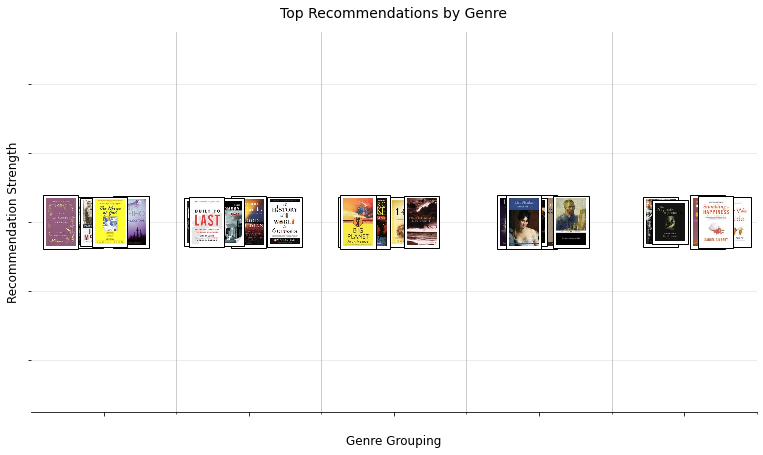

In [176]:
# Display top preds
display_top_books(top_preds_GD, df_books, target_user_ratings)

In [177]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(gd_neighborhoodhood_ratings, n=50, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,similar_usr_avg,ratings_count,year,%_similar_usr_read,url
1536,Ready Player One,4.31,3.99,376328.0,2011.0,9.2%,https://www.goodreads.com/book/show/9969571-re...
2394,The Martian,4.39,4.30,435440.0,2014.0,8.8%,https://www.goodreads.com/book/show/18007564-t...
2286,"The Hunger Games (The Hunger Games, #1)",4.34,3.60,4899965.0,2008.0,6.3%,https://www.goodreads.com/book/show/2767052-th...
2427,The Name of the Wind (The Kingkiller Chronicle...,4.55,4.42,416634.0,2007.0,5.3%,https://www.goodreads.com/book/show/186074.The...
211,"Ancillary Justice (Imperial Radch, #1)",3.97,3.95,40736.0,2013.0,4.4%,https://www.goodreads.com/book/show/17333324-a...
187,"American Gods (American Gods, #1)",4.11,3.92,379668.0,2005.0,4.3%,https://www.goodreads.com/book/show/4407.Ameri...
377,Brave New World,3.97,3.86,1043619.0,1998.0,4.3%,https://www.goodreads.com/book/show/5129.Brave...
1386,"Old Man's War (Old Man's War, #1)",4.23,3.94,100702.0,2007.0,4.0%,https://www.goodreads.com/book/show/51964.Old_...
2563,The Road,3.95,3.76,513565.0,2006.0,4.0%,https://www.goodreads.com/book/show/6288.The_Road
2770,"The Way of Kings (The Stormlight Archive, #1)",4.64,4.52,151473.0,2010.0,3.9%,https://www.goodreads.com/book/show/7235533-th...


In [178]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(gd_neighborhoodhood_ratings, n=50, write_to_excel=False)
top_rated.head(20)

,title,avg_rating,similar_usr_avg,ratings_count,year,url
307,Being Mortal: Medicine and What Matters in the...,4.41,5.00,60064.0,2014.0,https://www.goodreads.com/book/show/20696006-b...
1014,Influence: The Psychology of Persuasion,4.18,5.00,47682.0,2006.0,https://www.goodreads.com/book/show/28815.Infl...
385,Bridge of Birds (The Chronicles of Master Li a...,4.30,4.83,8063.0,1985.0,https://www.goodreads.com/book/show/15177.Brid...
1407,One Flew Over the Cuckoo's Nest,4.19,4.83,498475.0,1963.0,https://www.goodreads.com/book/show/332613.One...
1176,Lonesome Dove,4.47,4.80,113308.0,1999.0,https://www.goodreads.com/book/show/256008.Lon...
1011,Infinite Jest,4.31,4.80,47926.0,2005.0,https://www.goodreads.com/book/show/6759.Infin...
1774,"Steelheart (Reckoners, #1)",4.16,4.80,12473.0,2013.0,https://www.goodreads.com/book/show/15704458-s...
239,Aristotle and Dante Discover the Secrets of th...,4.34,4.71,114429.0,2012.0,https://www.goodreads.com/book/show/12000020-a...
2889,"Unbroken: A World War II Story of Survival, Re...",4.39,4.62,504961.0,2010.0,https://www.goodreads.com/book/show/8664353-un...
1292,Mother Night,4.21,4.62,53698.0,1961.0,https://www.goodreads.com/book/show/9592.Mothe...


In [179]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=3.9, 
    n_recs=20,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Musashi,4.43,5.00,9833.0,1995.0,https://www.goodreads.com/book/show/102030.Mus...
1,Infections and Inequalities: The Modern Plagues,4.08,5.00,2315.0,2001.0,https://www.goodreads.com/book/show/10233.Infe...
2,Why New Orleans Matters,3.94,3.00,845.0,2005.0,https://www.goodreads.com/book/show/113274.Why...
3,The Art of Hearing Heartbeats,3.98,5.00,42944.0,2012.0,https://www.goodreads.com/book/show/11331421-t...
4,Goodbye Sarajevo,4.18,4.00,605.0,2011.0,https://www.goodreads.com/book/show/11170615-g...
5,Always Running,4.03,3.50,4964.0,2005.0,https://www.goodreads.com/book/show/112148.Alw...
6,The Guns of August,4.18,4.00,36485.0,2004.0,https://www.goodreads.com/book/show/11366.The_...
7,The Orphan Master's Son,4.06,4.67,54592.0,2012.0,https://www.goodreads.com/book/show/11529868-t...
8,We Wish to Inform You That Tomorrow We Will Be...,4.29,3.50,19564.0,1998.0,https://www.goodreads.com/book/show/11472.We_W...
9,"Only Time Will Tell (The Clifton Chronicles, #1)",4.04,2.00,42324.0,2011.0,https://www.goodreads.com/book/show/10872085-o...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"Blood Meridian, or the Evening Redness in the ...",4.18,3.67,72755.0,1992.0,https://www.goodreads.com/book/show/394535.Blo...
1,Innovation and Entrepreneurship: Practice and ...,4.03,5.00,6233.0,1993.0,https://www.goodreads.com/book/show/114841.Inn...
2,The March of Folly: From Troy to Vietnam,4.03,4.00,3772.0,1985.0,https://www.goodreads.com/book/show/10302.The_...
3,Poor Economics: A Radical Rethinking of the Wa...,4.22,5.00,6643.0,2011.0,https://www.goodreads.com/book/show/10245602-p...
4,Ghost in the Wires: My Adventures as the World...,3.95,3.25,13185.0,2011.0,https://www.goodreads.com/book/show/10256723-g...
5,Counterinsurgency Warfare: Theory and Practice,3.98,4.00,749.0,2000.0,https://www.goodreads.com/book/show/113456.Cou...
6,The Smartest Guys in the Room: The Amazing Ris...,4.15,5.00,10753.0,2004.0,https://www.goodreads.com/book/show/113576.The...
7,The Story of My Experiments With Truth,4.07,4.00,29125.0,1993.0,https://www.goodreads.com/book/show/112803.The...
8,Buffett: The Making of an American Capitalist,4.24,4.00,6881.0,1996.0,https://www.goodreads.com/book/show/1155.Buffett
9,Deng Xiaoping and the Transformation of China,4.27,4.00,879.0,2011.0,https://www.goodreads.com/book/show/11472345-d...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Ringworld (Ringworld #1),3.96,2.00,2199.0,1970.0,https://www.goodreads.com/book/show/398274.Rin...
1,Everything You Ever Wanted to Know About Zombies,3.96,3.00,432.0,2011.0,https://www.goodreads.com/book/show/11988640-e...
2,The Algebraist,4.00,2.50,13414.0,2006.0,https://www.goodreads.com/book/show/12009.The_...
3,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,4.17,225626.0,1996.0,https://www.goodreads.com/book/show/13.The_Ult...
4,"Partials (Partials, #1)",3.94,1.00,866.0,2012.0,https://www.goodreads.com/book/show/13016732-p...
5,"Earth Unaware (The First Formic War, #1)",3.92,3.00,29543.0,2012.0,https://www.goodreads.com/book/show/13151129-e...
6,Inconstant Moon,4.05,4.00,712.0,1974.0,https://www.goodreads.com/book/show/1255867.In...
7,"Black: The Birth of Evil (The Circle, #1)",4.21,2.00,23893.0,2005.0,https://www.goodreads.com/book/show/125956.Black
8,Silently and Very Fast,4.13,5.00,1126.0,2011.0,https://www.goodreads.com/book/show/12887497-s...
9,"Grass (Arbai, #1)",4.04,3.33,7423.0,2002.0,https://www.goodreads.com/book/show/104342.Grass


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Harry Potter and the Methods of Rationality,4.38,4.75,8691.0,2015.0,https://www.goodreads.com/book/show/10016013-h...
1,Hard to Be a God,4.23,5.00,4485.0,1964.0,https://www.goodreads.com/book/show/759517.Har...
2,Sandalwood Death,4.15,5.00,236.0,2012.0,https://www.goodreads.com/book/show/16087986-s...
3,"Uncertainty: Einstein, Heisenberg, Bohr, and t...",3.97,4.00,1490.0,2007.0,https://www.goodreads.com/book/show/161452.Unc...
4,The Humans,4.07,3.60,17904.0,2013.0,https://www.goodreads.com/book/show/16130537-t...
5,The Conquest of Bread,4.16,5.00,1327.0,2006.0,https://www.goodreads.com/book/show/1113155.Th...
6,Before the Dawn: Recovering the Lost History o...,4.00,4.00,3063.0,2007.0,https://www.goodreads.com/book/show/110995.Bef...
7,The 100: A Ranking of the Most Influential Per...,4.00,4.00,1972.0,2000.0,https://www.goodreads.com/book/show/108449.The...
8,Where I'm Calling From: New and Selected Stories,4.42,4.00,16866.0,2000.0,https://www.goodreads.com/book/show/11437.Wher...
9,Church History in Plain Language,4.13,3.00,1410.0,1982.0,https://www.goodreads.com/book/show/111596.Chu...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Bringing Up Bébé: One American Mother Discover...,3.95,4.00,18924.0,2012.0,https://www.goodreads.com/book/show/13152287-b...
1,The Power Of Habit: Why We Do What We Do In Li...,4.03,2.00,6869.0,2012.0,https://www.goodreads.com/book/show/12609434-t...
2,The Power of Habit: Why We Do What We Do in Li...,4.03,4.33,160604.0,2012.0,https://www.goodreads.com/book/show/12609433-t...
3,The Advantage: Why Organizational Health Trump...,4.14,4.00,5093.0,2012.0,https://www.goodreads.com/book/show/12975375-t...
4,Search Inside Yourself: The Unexpected Path to...,4.10,4.00,2817.0,2012.0,https://www.goodreads.com/book/show/12921211-s...
5,Mobile First,3.98,3.00,1603.0,2011.0,https://www.goodreads.com/book/show/12910749-m...
6,Do the Work,4.01,5.00,7536.0,2011.0,https://www.goodreads.com/book/show/10645233-d...
7,Start Something That Matters,4.05,4.00,6553.0,2011.0,https://www.goodreads.com/book/show/10723236-s...
8,The Lean Startup: How Today's Entrepreneurs Us...,4.04,4.50,95622.0,2011.0,https://www.goodreads.com/book/show/10127019-t...
9,Vagabonding: An Uncommon Guide to the Art of L...,3.92,5.00,13658.0,2002.0,https://www.goodreads.com/book/show/100247.Vag...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"Shōgun (Asian Saga, #1)",4.37,4.00,106404.0,2009.0,https://www.goodreads.com/book/show/402093.Sh_gun
1,The Afghan Campaign,3.94,4.00,2600.0,2006.0,https://www.goodreads.com/book/show/1315.The_A...
2,A Song for Arbonne,4.19,5.00,9985.0,1992.0,https://www.goodreads.com/book/show/104085.A_S...
3,A Town Like Alice,4.12,3.00,36749.0,2000.0,https://www.goodreads.com/book/show/107301.A_T...
4,The Lions of Al-Rassan,4.27,4.67,14200.0,2005.0,https://www.goodreads.com/book/show/104101.The...
5,"Sailing to Sarantium (The Sarantine Mosaic, #1)",4.15,4.00,9076.0,2002.0,https://www.goodreads.com/book/show/104097.Sai...
6,Tigana,4.12,3.91,31488.0,1999.0,https://www.goodreads.com/book/show/104089.Tigana
7,Much Ado About Nothing,4.06,4.00,177549.0,2004.0,https://www.goodreads.com/book/show/12957.Much...
8,"Genghis: Birth of an Empire (Conqueror, #1)",4.34,4.00,16877.0,2008.0,https://www.goodreads.com/book/show/1279686.Ge...
9,"The Lies of Locke Lamora (Gentleman Bastard, #1)",4.30,4.48,123373.0,2006.0,https://www.goodreads.com/book/show/127455.The...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Beyond Religion: Ethics for a Whole World,4.11,3.00,2518.0,2011.0,https://www.goodreads.com/book/show/11346463-b...
1,Orthodoxy and Heterodoxy,4.25,4.00,183.0,2011.0,https://www.goodreads.com/book/show/11352140-o...
2,The Righteous Mind: Why Good People are Divide...,4.16,4.67,13500.0,2012.0,https://www.goodreads.com/book/show/11324722-t...
3,With: Reimagining the Way You Relate to God,4.33,5.00,850.0,2011.0,https://www.goodreads.com/book/show/11390621-with
4,Comfortable with Uncertainty: 108 Teachings on...,4.35,5.00,3156.0,2003.0,https://www.goodreads.com/book/show/108829.Com...
5,Einstein: His Life and Universe,4.08,4.40,73712.0,2007.0,https://www.goodreads.com/book/show/10884.Eins...
6,Reminiscences of a Stock Operator,4.16,3.00,7916.0,1923.0,https://www.goodreads.com/book/show/100779.Rem...
7,"""Multiplication Is for White People"": Raising ...",4.09,5.00,634.0,2012.0,https://www.goodreads.com/book/show/10823748-m...
8,The Screwtape Letters,4.21,3.67,116487.0,2001.0,https://www.goodreads.com/book/show/11149.The_...
9,The Better Angels of Our Nature: Why Violence ...,4.20,5.00,11991.0,2011.0,https://www.goodreads.com/book/show/11107244-t...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Etymologicon: A Circular Stroll through th...,4.21,4.5,4106.0,2011.0,https://www.goodreads.com/book/show/12870068-t...
1,The Life and Times of the Thunderbolt Kid,3.93,3.0,43320.0,2006.0,https://www.goodreads.com/book/show/10538.The_...
2,Twice Born,4.27,4.0,1509.0,2011.0,https://www.goodreads.com/book/show/10725494-t...
3,Sam Walton: Made In America,4.08,4.0,9761.0,1992.0,https://www.goodreads.com/book/show/10631.Sam_...
4,Dress Your Family in Corduroy and Denim,4.09,3.0,194885.0,2004.0,https://www.goodreads.com/book/show/10176.Dres...
5,Zen in the Art of Writing,4.11,4.0,8655.0,1992.0,https://www.goodreads.com/book/show/103761.Zen...
6,The Color Purple,4.17,3.8,380851.0,2004.0,https://www.goodreads.com/book/show/11486.The_...
7,Tiny Beautiful Things: Advice on Love and Life...,4.29,5.0,35189.0,2012.0,https://www.goodreads.com/book/show/13152194-t...
8,No One Writes Back,4.19,1.0,154.0,2013.0,https://www.goodreads.com/book/show/17591572-n...
9,A Streetcar Named Desire,3.97,4.0,202539.0,1952.0,https://www.goodreads.com/book/show/12220.A_St...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Amazing Adventures of Kavalier & Clay,4.17,4.00,149976.0,2000.0,https://www.goodreads.com/book/show/3985.The_A...
1,Song of Solomon,4.01,5.00,61137.0,2004.0,https://www.goodreads.com/book/show/11334.Song...
2,The Bluest Eye,3.99,4.00,111515.0,2005.0,https://www.goodreads.com/book/show/11337.The_...
3,The Snow Child,3.95,4.00,74041.0,2012.0,https://www.goodreads.com/book/show/11250053-t...
4,What We Talk About When We Talk About Love,4.22,4.00,30437.0,1989.0,https://www.goodreads.com/book/show/11438.What...
5,Cathedral,4.29,5.00,18834.0,1989.0,https://www.goodreads.com/book/show/11449.Cath...
6,We Others: New and Selected Stories,3.91,3.00,603.0,2011.0,https://www.goodreads.com/book/show/10796178-w...
7,"The Rook (The Checquy Files, #1)",4.12,3.40,28588.0,2012.0,https://www.goodreads.com/book/show/10836728-t...
8,The Spectator Bird,3.97,5.00,4009.0,1990.0,https://www.goodreads.com/book/show/11045.The_...
9,Light in August,3.93,4.00,42719.0,1932.0,https://www.goodreads.com/book/show/10979.Ligh...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,4.00,35184.0,1997.0,https://www.goodreads.com/book/show/386162.The...
1,The Year's Best Science Fiction: Twenty-Ninth ...,3.92,3.00,186.0,2012.0,https://www.goodreads.com/book/show/13513326-t...
2,Amory Wars: In Keeping Secrets of Silent Earth...,4.42,5.00,381.0,2012.0,https://www.goodreads.com/book/show/12290702-a...
3,The Only Astrology Book You'll Ever Need,4.19,4.00,1448.0,1982.0,https://www.goodreads.com/book/show/120991.The...
4,"The Hedge Knight (The Tales of Dunk and Egg, #1)",4.23,3.50,14640.0,2005.0,https://www.goodreads.com/book/show/11970747-t...
5,The Complete Works of H.P. Lovecraft,4.34,4.00,9733.0,2011.0,https://www.goodreads.com/book/show/11851522-t...
6,The Line Between,4.13,5.00,648.0,2006.0,https://www.goodreads.com/book/show/11932.The_...
7,At the Mouth of the River of Bees: Stories,4.06,5.00,1401.0,2012.0,https://www.goodreads.com/book/show/12970063-a...
8,Effective Java Programming Language Guide,4.45,4.00,3571.0,2001.0,https://www.goodreads.com/book/show/105099.Eff...
9,The Garden of Forking Paths,4.40,5.00,1326.0,2010.0,https://www.goodreads.com/book/show/10438328-t...


_____



### Appendix: Find Similar User Ratings by Searching Title

In [180]:
title_search = "way of kings"

In [181]:
# Search neighborhoods for title_search, get similar user ratings
for i in range(3):
    
    df = [sm_neighborhood_ratings, med_neighborhood_ratings, lg_neighborhood_ratings][i]
    
    if i == 0:
        print("Small Neighborhood")
    elif i == 1: 
        print("Medium Neighborhood")
    elif i == 2:
        print("Large Neighborhood")

    filtered = df[df["title"].str.lower().str.contains(title_search)]
    grouped = filtered.groupby(["title", "main_genre", "avg_rating"])["user_rating"].agg(["mean","count"])\
                        .reset_index().sort_values(by="count", ascending=False)\
                            .rename(columns={"mean":"sim_reader_avg"})
    grouped["sim_reader_avg"] = grouped["sim_reader_avg"].round(2)

    if len(grouped) > 0:
        display(grouped)
        print("______________\n")
    else:
        print("Book not found")
        print("______________\n")


Small Neighborhood


,title,main_genre,avg_rating,sim_reader_avg,count
0,"The Way of Kings (The Stormlight Archive, #1)",15.0,4.64,4.6,5


______________

Medium Neighborhood


,title,main_genre,avg_rating,sim_reader_avg,count
0,"The Way of Kings (The Stormlight Archive, #1)",15.0,4.64,4.52,33
1,"The Way of Kings, Part 1 (The Stormlight Archi...",26.0,4.67,5.00,1


______________

Large Neighborhood


,title,main_genre,avg_rating,sim_reader_avg,count
1,"The Way of Kings (The Stormlight Archive, #1)",15.0,4.64,4.62,99
2,"The Way of Kings, Part 1 (The Stormlight Archi...",26.0,4.67,4.25,4
3,"The Way of Kings, Part 2 (The Stormlight Archi...",15.0,4.78,5.00,2
0,The Stormlight Archive - A Pocket Companion to...,13.0,3.85,5.00,1


______________

